# Import packages

In [1]:
import numpy as np
import nibabel as nib
import sys
import os
import scipy
import pandas as pd
import time
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

# Set directory

In [6]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_19'

# Define functions

In [24]:
def load_fictrac(directory, file='fictrac.dat'):
    for item in os.listdir(directory):
        if '.dat' in item:
            file = item

    with open(os.path.join(directory, file),'r') as f:
        df = pd.DataFrame(l.rstrip().split() for l in f)

        # Name columns
        df = df.rename(index=str, columns={0: 'frameCounter',
                                       1: 'dRotCamX',
                                       2: 'dRotCamY',
                                       3: 'dRotCamZ',
                                       4: 'dRotScore',
                                       5: 'dRotLabX',
                                       6: 'dRotLabY',
                                       7: 'dRotLabZ',
                                       8: 'AbsRotCamX',
                                       9: 'AbsRotCamY',
                                       10: 'AbsRotCamZ',
                                       11: 'AbsRotLabX',
                                       12: 'AbsRotLabY',
                                       13: 'AbsRotLabZ',
                                       14: 'positionX',
                                       15: 'positionY',
                                       16: 'heading',
                                       17: 'runningDir',
                                       18: 'speed',
                                       19: 'integratedX',
                                       20: 'integratedY',
                                       21: 'timeStamp',
                                       22: 'sequence'})

        # Remove commas
        for column in df.columns.values[:-1]:
            df[column] = [float(x[:-1]) for x in df[column]]
                
    return df

def interp_fictrac(fictrac, behavior, fps, expt_len, timestamps):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    sphere_radius = 4.5e-3
    filter_window = 51
    
    x_original = np.arange(0,expt_len,camera_rate)
    
    if behavior == 'Y':
        dy = np.asarray(fictrac['dRotLabY'])
        fictrac_smoothed = savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
    elif behavior == 'Z':
        dz = np.asarray(fictrac['dRotLabZ'])
        fictrac_smoothed = savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
    elif behavior == 'heading':
        fictrac_smoothed = np.asarray(fictrac['heading'])
        #fictrac_smoothed = savgol_filter(heading,filter_window,3)
    else:
        print('invalid behavior')
    
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)    
    fictrac_interp = fictrac_interp_temp(timestamps[:,25])

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

def load_timestamps(directory):
    with h5py.File(os.path.join(directory, 'timestamps.h5'), 'r') as hf:
        timestamps = hf['timestamps'][:]
    return timestamps

# Load behavior

In [8]:
fictrac = load_fictrac(os.path.join(directory,'func_0','fictrac'))

# Load imaging timestamps

In [10]:
timestamps = load_timestamps(os.path.join(directory,'func_0','imaging'))

# Load imaging data

Note: I always load everything into memory with the .get_data(). You can exlude that, and presumably load only what you need when you need it, but I don't know how that works.

Note: shape is (128,84,49,4554) or (x,y,z,t)

In [15]:
brain_file = os.path.join(directory, 'motcorr_green.nii')
brain = nib.load(brain_file).get_data()

Duration: 0s


In [102]:
brain.shape

(128, 84, 49, 4554)

# Load PCs (if desired)

In [20]:
save_file = os.path.join(directory, 'scores_(spatial).npy')
pca_spatial = np.load(save_file)
save_file = os.path.join(directory, 'loadings_(temporal).npy')
pca_loadings = np.load(save_file)
# Fix shape
pca_spatial.shape = (4554, -1)
pca_spatial.shape = (4554, 128, 84, 49)

# Interpolate behavior to match neural data

Note: fictracs['Y'] will be forward velocity (mm/sec), fictracs['Z'] will be rotational velocity (deg/sec).

Note: Although each z-slice has a slightly different time, I use one timestamp for each volume, which is set to the timestamp of the middle slice.

In [25]:
expt_len = 1000*30*60 #in ms
fps = 50 #of fictrac camera

fictracs = {}
for behavior in ['Y', 'Z','heading']:
    fictracs[behavior] = interp_fictrac(fictrac, behavior, fps, expt_len, timestamps)

/home/users/brezovec/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


# Example viewing neural data

Text(0.5, 1.0, 'slice 20 at timepoint 0')

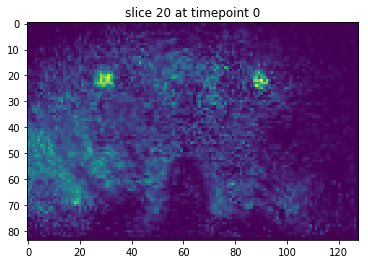

In [116]:
plt.imshow(brain[:,:,20,0].T)
plt.title('slice 20 at timepoint 0')

# Example viewing behavior

Text(0.5, 0, 'Time, sec')

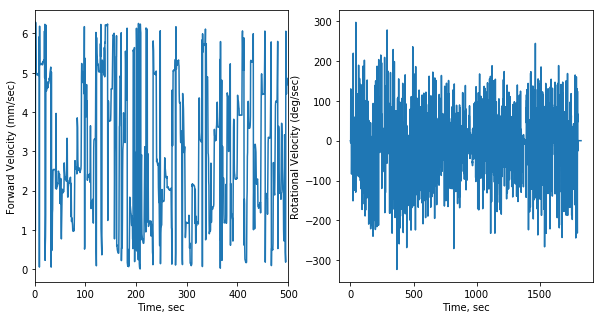

In [29]:
plt.figure(figsize=(10,5))

ax = plt.subplot(121)
ax.plot(timestamps[:,25]/1000, fictracs['heading'])
ax.set_ylabel('Forward Velocity (mm/sec)')
ax.set_xlabel('Time, sec')
ax.set_xlim(0,500)

ax = plt.subplot(122)
ax.plot(timestamps[:,25]/1000, fictracs['Z'])
ax.set_ylabel('Rotational Velocity (deg/sec)')
ax.set_xlabel('Time, sec')

In [27]:
np.max(fictracs['heading'])

6.28316959192113

In [28]:
2*np.pi

6.283185307179586

# Example viewing PCs

Text(0.5, 1.0, 'PC1')

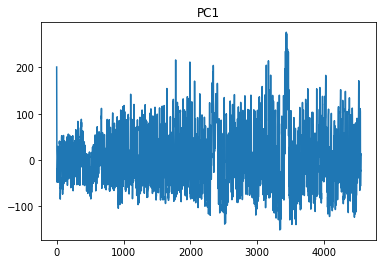

In [48]:
plt.plot(pca_loadings[:,0])
plt.title('PC1')

Text(0.5, 1.0, 'Spatial weightings of PC1 in slice 25')

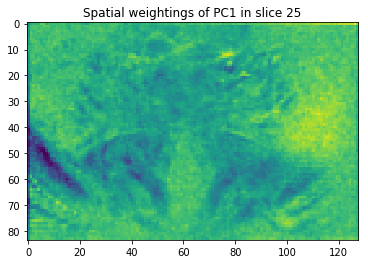

In [52]:
plt.imshow(pca_spatial[0,:,:,25].T)
plt.title('Spatial weightings of PC1 in slice 25')